# 0.0 - Imports

In [1]:
import math
import numpy as np
import pandas as pd
import inflection
import seaborn as sns
from scipy import stats as ss
from matplotlib import pyplot as plt


from IPython.display import Image
from IPython.core.display import HTML
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
import datetime
from scipy import stats

from matplotlib import gridspec


## 0.1 - Helper Function

In [75]:
def cramer_v (x, y):
    cm = pd.crosstab(x, y).values    
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [76]:
jupyter_settings

<function __main__.jupyter_settings()>

## 0.2 - Loading data

In [4]:
df_sales_raw = pd.read_csv('Data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('Data/store.csv', low_memory = False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 - Passo 1 - Data description

In [5]:
df1= df_raw.copy()

## 1.1 - Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map( snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2 - Data Dimention

In [7]:
print ('Number of rows: {}'.format(df1.shape[0]))
print ('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## 1.3 - Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 - Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 - Fillout NA

In [10]:
# competition_distance    
# to resolve the NA values in this column, we'll give all those lines a value far greater than the max value found in the DF
# therefore basically saying there is no competition nearby
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month 
                                                    if math.isnan(x['competition_open_since_month'])
                                                    else x['competition_open_since_month'], axis=1)

# competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year 
                                                    if math.isnan(x['competition_open_since_year'])
                                                    else x['competition_open_since_year'], axis=1)

# promo2_since_week  
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week 
                                                    if math.isnan(x['promo2_since_week'])
                                                    else x['promo2_since_week'], axis=1)

# promo2_since_year           
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year 
                                                    if math.isnan(x['promo2_since_year'])
                                                    else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']== 0 
                                                                         else 1 
                                                                         if x['month_map'] in x['promo_interval'].split(',') 
                                                                         else 0, axis=1 )

## 1.6 - Change Types

In [11]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
df1.dtypes


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 - Descriptive Statistics

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64', 'int32'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]', 'int32'])

### 1.7.1 - Numerical Attributs

In [13]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [14]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\filip\anaconda3\envs\DSemProducao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

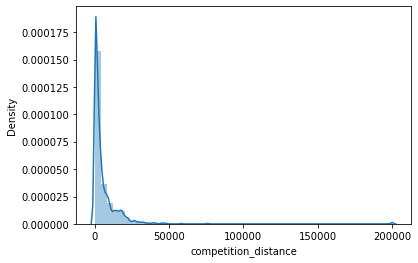

In [15]:
sns.distplot(df1['competition_distance'])

### 1.7.2 - Categorical Attributs

In [16]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

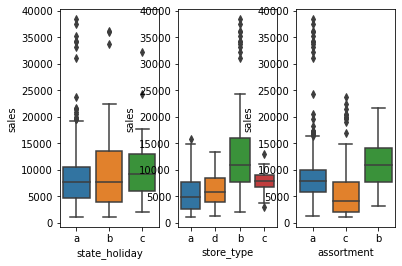

In [17]:
aux1 = df1[(df1['state_holiday'] != '0') &  df1['sales'] > 0]

plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1 )

# 2.0 - Passo 2 - Feature Engineering

In [18]:
df2 = df1.copy()

## 2.1 - Mindmap image

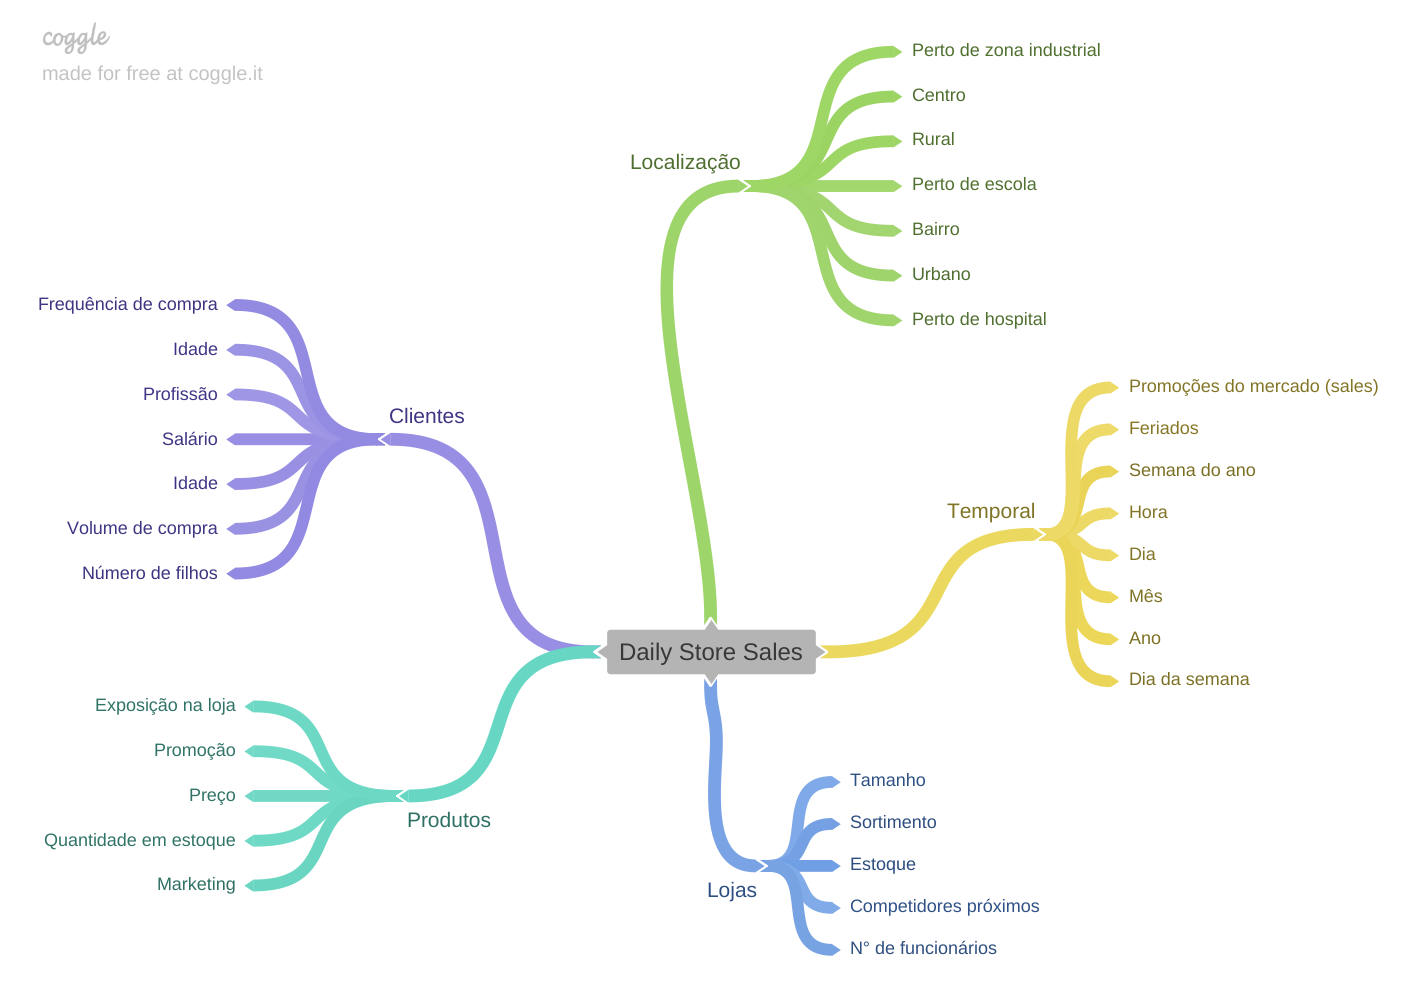

In [19]:
Image('img/Daily_Store_Sales.png')

## 2.2 - Mindmap hypothesis

### 2.1.1 - Store Hypothesis

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.1.2 - Product Hypothesis

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3 - Time Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 - Final Hypothesis List

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 - Feature Engineering

In [20]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of the year
df2['week_of_year'] = df2['date'].dt.week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                 month=x['competition_open_since_month'],
                                                                 day=1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)


# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - 
                                                        datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')


# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' 
                                                  else 'easter_holiday' if x == 'b' 
                                                  else 'christmas_holiday' if x == 'c'
                                                  else 'regular_day')

C:\Users\filip\AppData\Local\Temp\ipykernel_14076\1889290336.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.week


In [21]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 - Passo 3 - Variable Filtering

In [22]:
df3 = df2.copy()

## 3.1 - Filtering the lines

In [23]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 - Selecting the Columns

In [24]:
# Columns that we won't use for the prediction
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 - Passo 4 - Exploratory Data Analysis

In [25]:
df4 = df3.copy()

## 4.1 - Univariable Analysis

### 4.1.1 - Response Variable

C:\Users\filip\anaconda3\envs\DSemProducao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

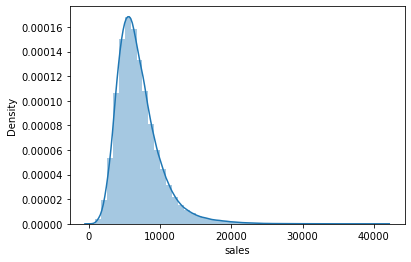

In [26]:
sns.distplot(df4['sales'])

### 4.1.2 - Numerical Variable

array([[<AxesSubplot:title={'center':'store'}>,
        <AxesSubplot:title={'center':'day_of_week'}>,
        <AxesSubplot:title={'center':'sales'}>,
        <AxesSubplot:title={'center':'customers'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'promo'}>,
        <AxesSubplot:title={'center':'school_holiday'}>,
        <AxesSubplot:title={'center':'competition_distance'}>],
       [<AxesSubplot:title={'center':'competition_open_since_month'}>,
        <AxesSubplot:title={'center':'competition_open_since_year'}>,
        <AxesSubplot:title={'center':'promo2'}>,
        <AxesSubplot:title={'center':'promo2_since_week'}>],
       [<AxesSubplot:title={'center':'promo2_since_year'}>,
        <AxesSubplot:title={'center':'is_promo'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

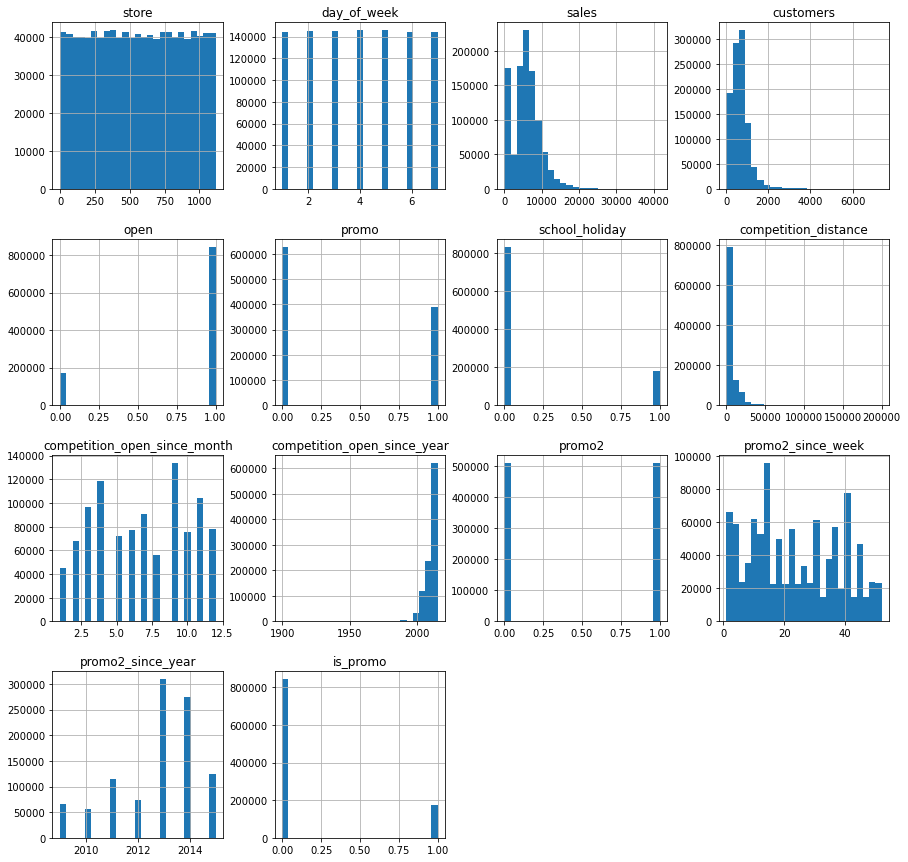

In [27]:
plt.rcParams["figure.figsize"] = (15,15)

num_attributes.hist(bins=25)

### 4.1.3 - Categorical Variable

In [28]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

C:\Users\filip\anaconda3\envs\DSemProducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\filip\anaconda3\envs\DSemProducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\filip\anaconda3\envs\DSemProducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpreta

<AxesSubplot:xlabel='sales', ylabel='Density'>

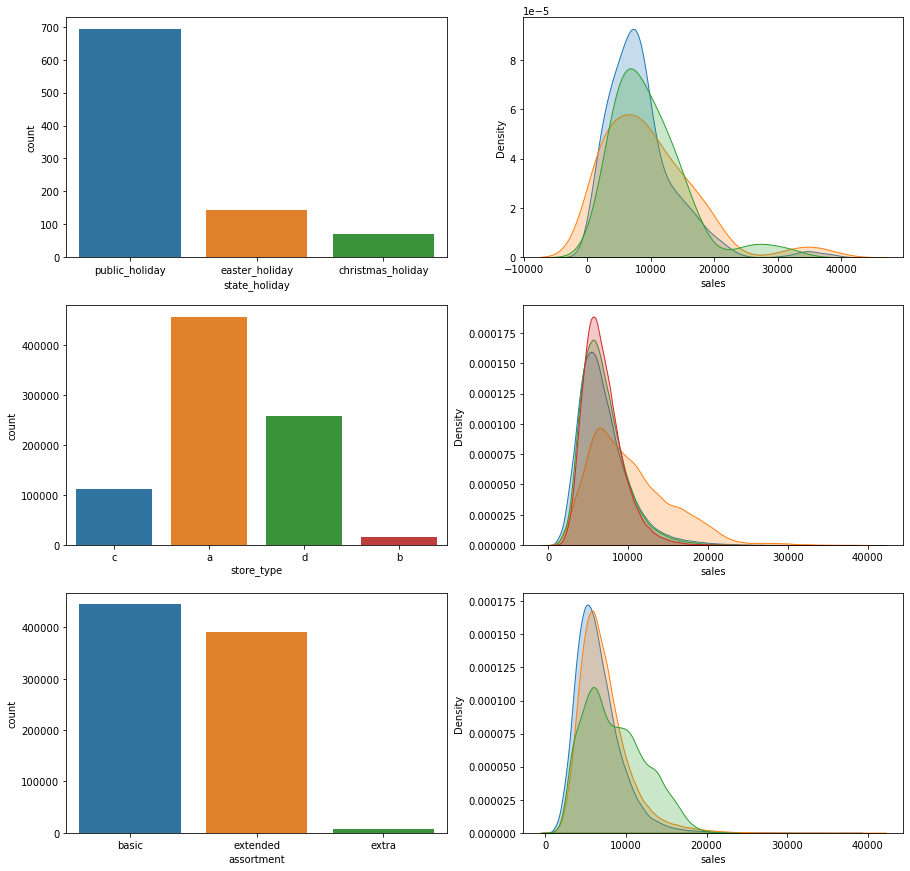

In [29]:
plt.rcParams["figure.figsize"] = (15,15)

# state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label ='public_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label ='easter_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas_holiday']['sales'], label ='christmas_holiday', shade = True)

# store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label ='a', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label ='b', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label ='c', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label ='d', shade = True)



# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label ='basic', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label ='extended', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label ='extra', shade = True)

## 4.2 - Bivariable Analysis

### **H1.** Lojas com maior sortimentos deveriam vender mais.

**A premissa é falsa!** - Na verdade, lojas com maior sortimento contribuem MENOS para o resultado final da empresa

<AxesSubplot:xlabel='year_week'>

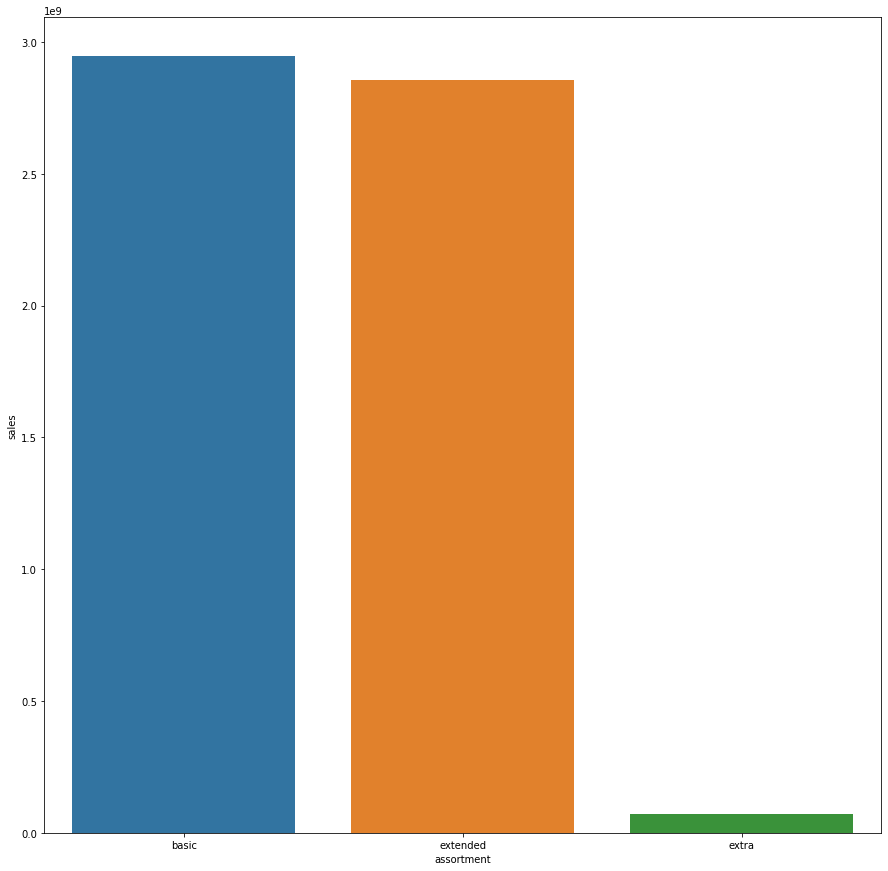

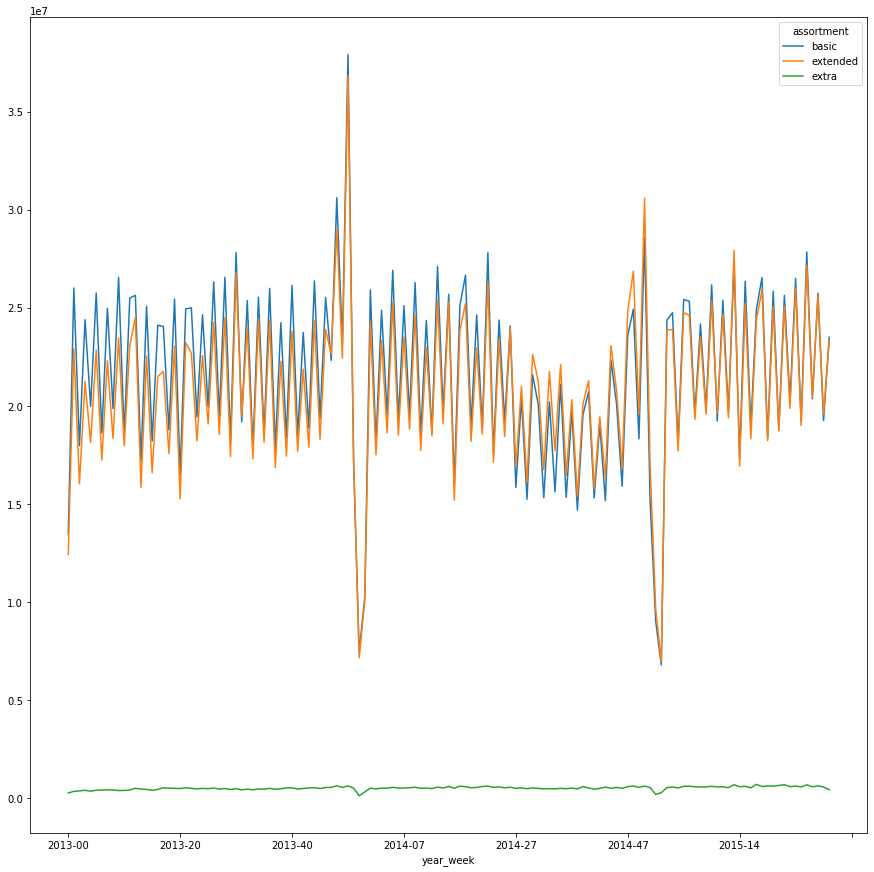

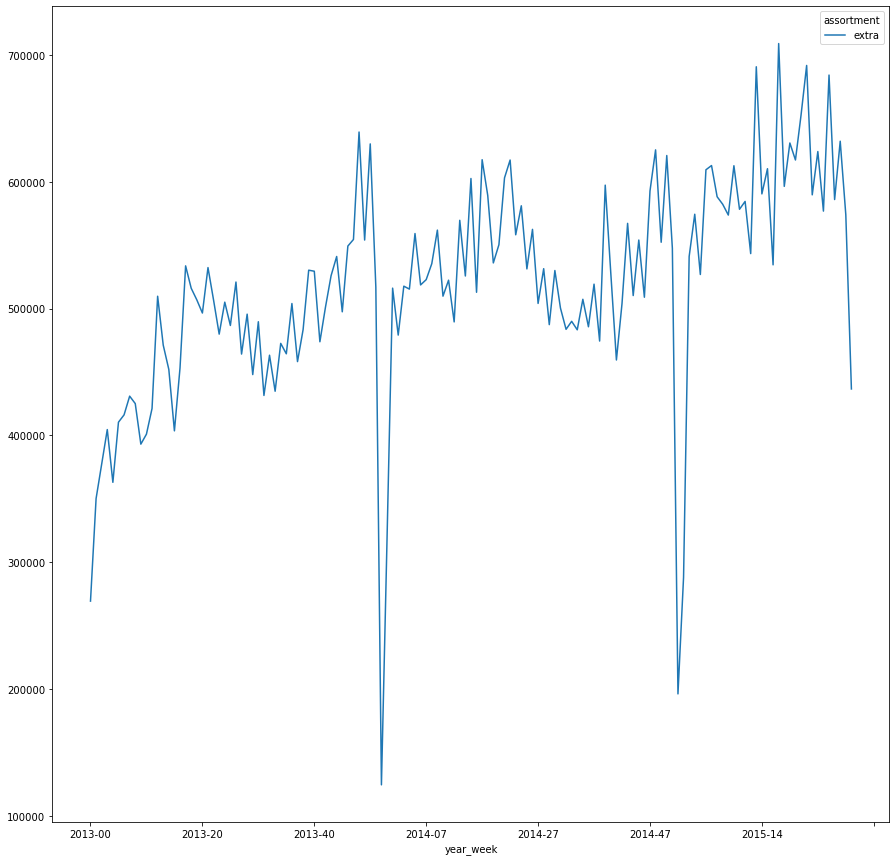

In [30]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1)

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**A premissa é falsa!** - Como conseguimos ver pelos gráficos abaixo, quanto mais próximo de outras lojas, mais vendemos. O mapa de calor mostra uma correlação modular de .23 entre a distância da competição e o valor de vendas.

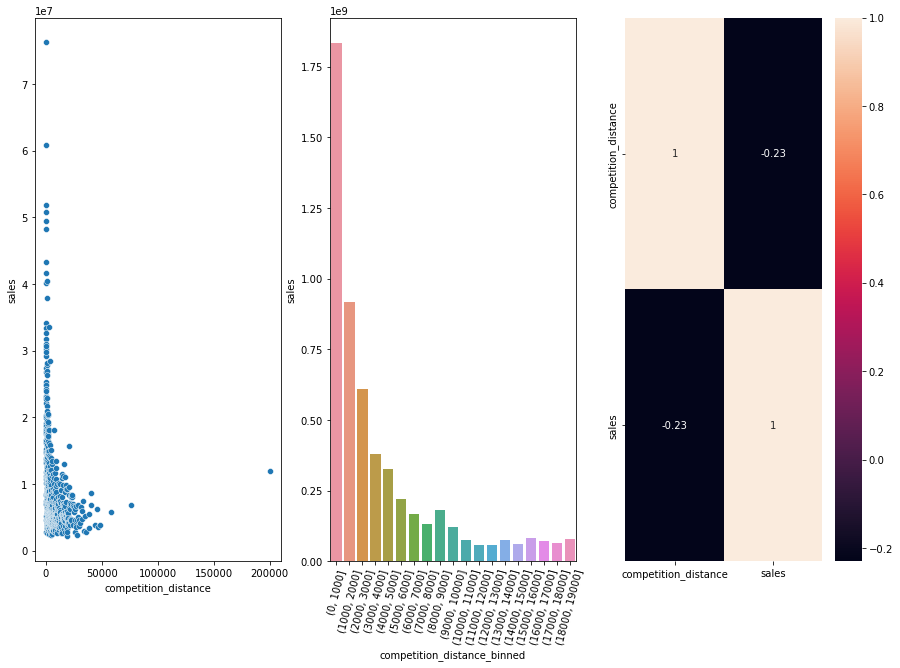

In [31]:
plt.rcParams["figure.figsize"] = (15,10)

aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
bins = list(np.arange (0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()

plt.subplot(1,3,2)
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks(rotation=75);

plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
**A premissa é falsa!** - Segundo os gráficos abaixo, lojas com mais tempo de competição aberta tendem a vender MENOS.


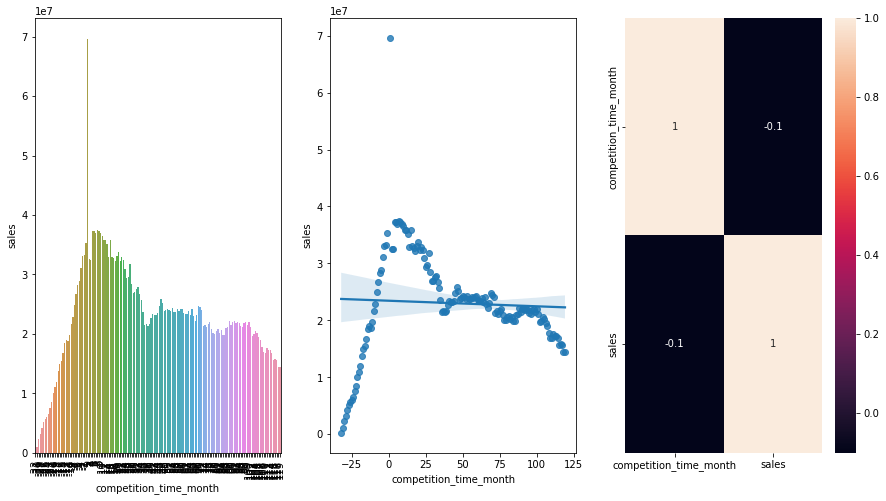

In [32]:
plt.rcParams["figure.figsize"] = (15,8)

plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);


plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**Falsa!** - Promoções rolando a mais tempo tendem a diminuir as vendas com o tempo 

In [33]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


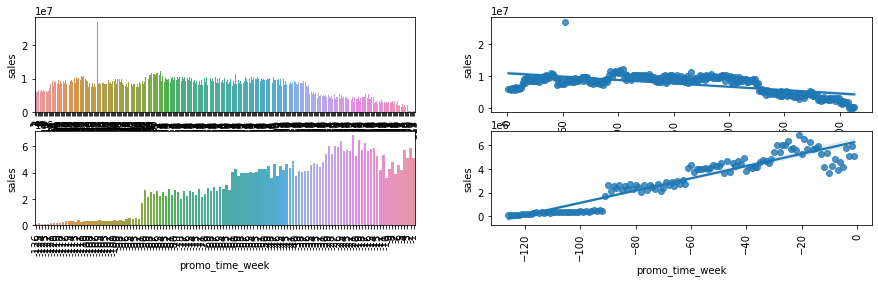

In [34]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
# sns.barplot(x = 'promo_time_week', y = 'sales', data = aux1);

grid = gridspec.GridSpec(4,2)

aux2 = aux1[aux1['promo_time_week'] > 0]  
plt.subplot(grid[0,0])
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation=90);

aux3 = aux1[aux1['promo_time_week'] < 0]
plt.subplot(grid[1,0])
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation=90);

# plt.subplot(grid[:,2])
# sns.heatmap (aux1.corr(method='pearson'));

# plt.subplot(grid[0,2])
# sns.heatmap (aux2.corr(method='pearson'));

# plt.subplot(grid[1,2])
# sns.heatmap (aux3.corr(method='pearson'));

### <s> **H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**Não parece fazer diferença** - elas aparentam ter o mesmo funcionamento

In [35]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


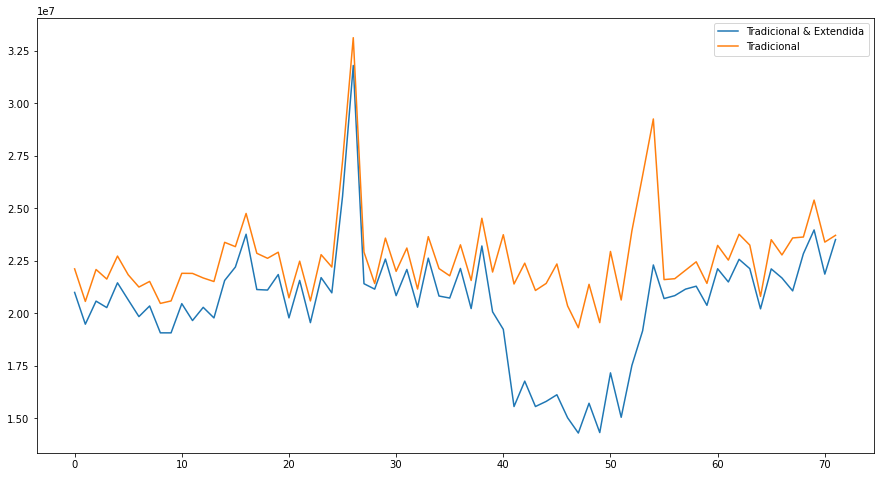

In [36]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Tradicional']);

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** - Lojas em feriados normais e na páscoa lucram mais 

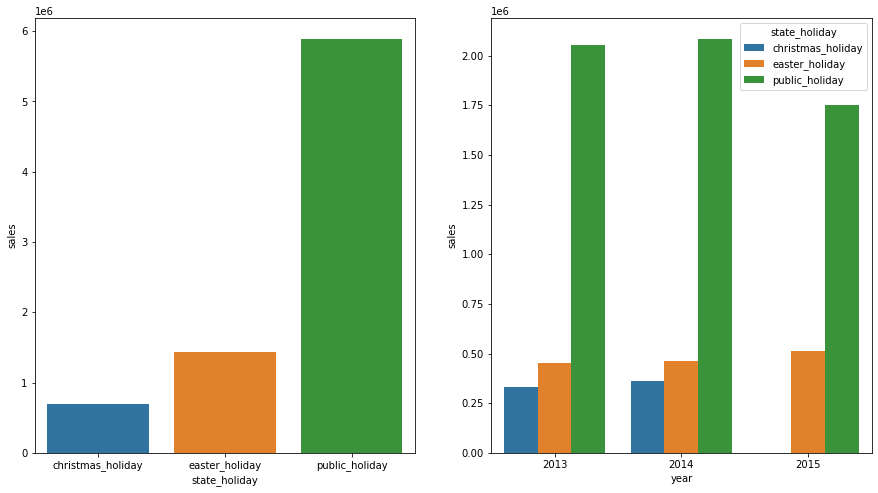

In [37]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1);

aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
plt.subplot(1,2,2)
sns.barplot(x = 'year', y = 'sales', hue='state_holiday', data = aux2);

### H8. Lojas deveriam vender mais ao longo dos anos.
**FALSO**, mas ainda precisamos de mais dados para ver isso, visto que o ano de 2015 ainda não terminou

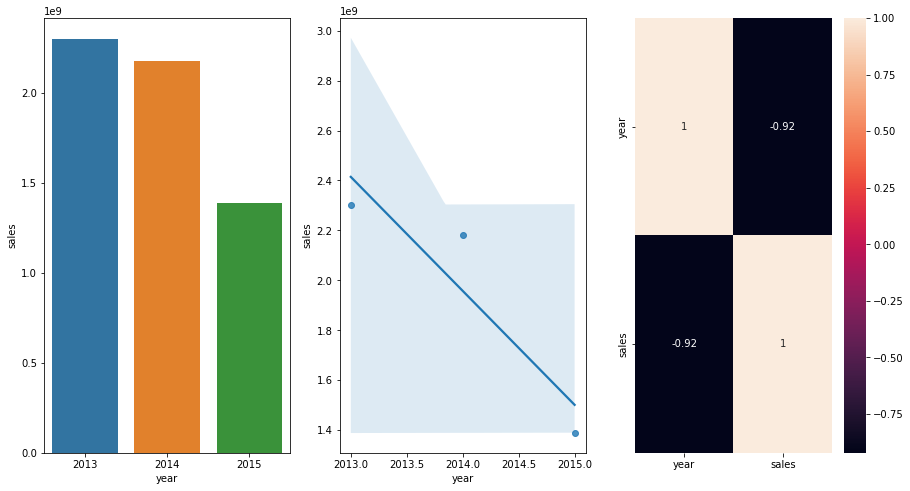

In [38]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);


### H9. Lojas deveriam vender mais no segundo semestre do ano.
**FALSO** Elas vendem menos ao longo do ano

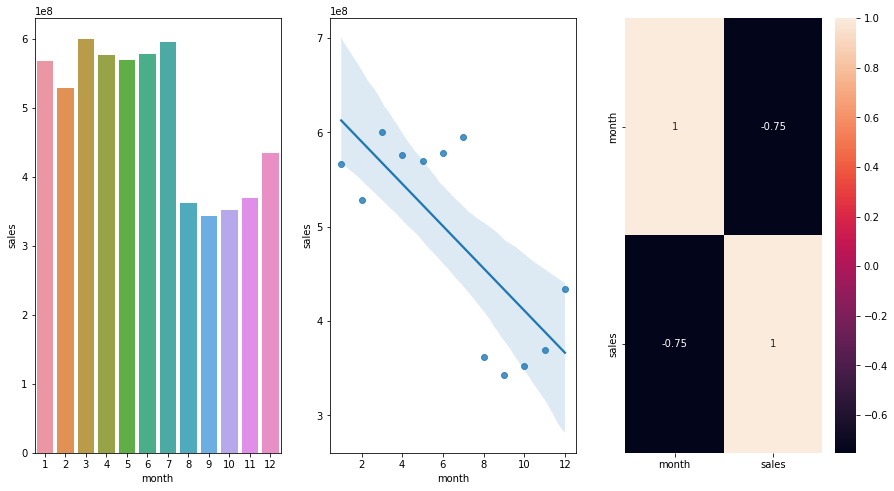

In [39]:
# aux1 = df4[['month','sales']].groupby('month').sum().reset_index()
# aux1 = df4[['month','sales']]


# bins = list(np.arange (0, 13, 6))

# aux1['sales_binned_for_semester'] = pd.cut(aux1['month'], bins=bins)
# aux2 = aux1[['sales_binned_for_semester','sales']].groupby('sales_binned_for_semester').sum().reset_index()
# sns.barplot(x = 'sales_binned_for_semester', y = 'sales', data = aux2)

# aux1['semester'] = 1 if 

aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);



### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRO** - as pessoas vão gastando menos ao longo dos dias, mas vendem basicamente 2x mais nos 20 últimos dias que nos primieros 10

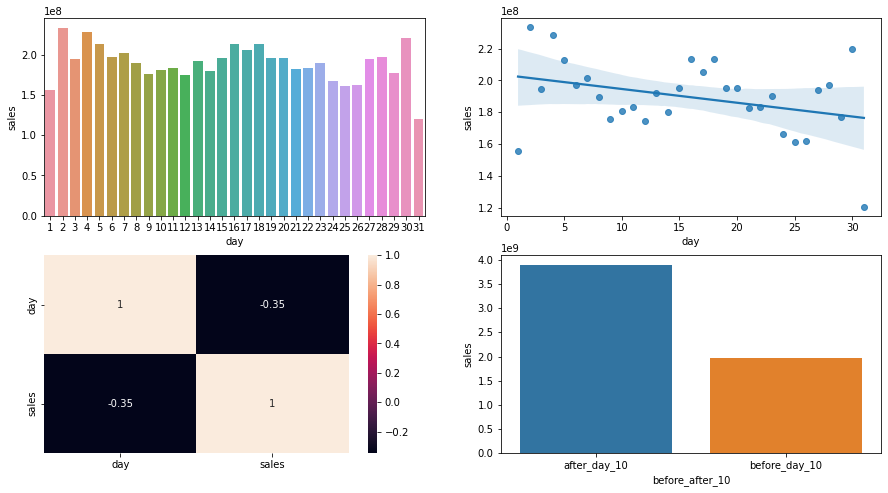

In [40]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
plt.subplot(2,2,1)
sns.barplot(x = 'day', y = 'sales', data = aux1);

plt.subplot(2,2,2)
sns.regplot(x = 'day', y = 'sales', data = aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

aux1['before_after_10'] = aux1['day'].apply(lambda x: 'before_day_10' if x <= 10 else 'after_day_10')
aux2 = aux1[['before_after_10', 'sales']].groupby('before_after_10').sum().reset_index()
plt.subplot(2,2,4)
sns.barplot(x = 'before_after_10', y = 'sales', data = aux2);



### H11. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRO**, mas no sábado vende quase o mesmo tanto que nos outros dias da semana, só no domingo que vende MUITO menos

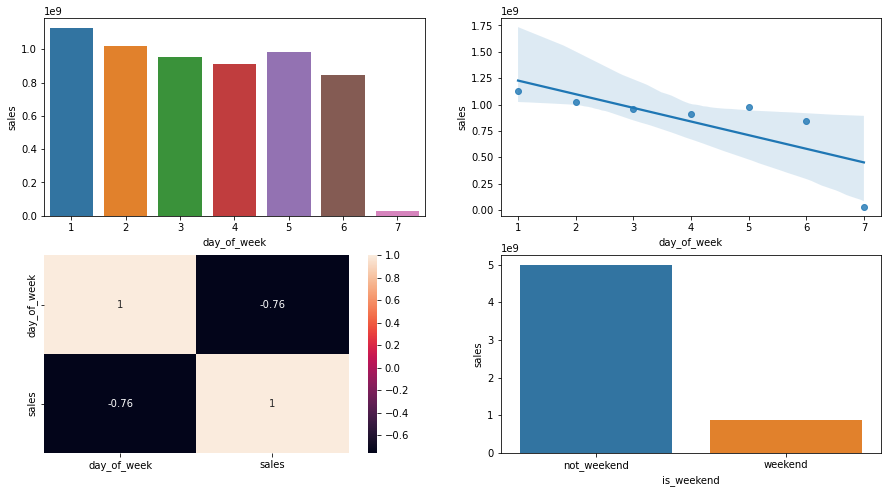

In [41]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(2,2,2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

aux1['is_weekend'] = aux1['day_of_week'].apply(lambda x: 'not_weekend' if x <= 5 else 'weekend' )
aux2 = aux1[['is_weekend', 'sales']].groupby('is_weekend').sum().reset_index()
plt.subplot(2,2,4)
sns.barplot(x = 'is_weekend', y = 'sales', data = aux2);

### H12. Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRO** - Mas nos meses 7 temos quase o mesmo tanto de vendas em school holiday ou não e mais no mês 8

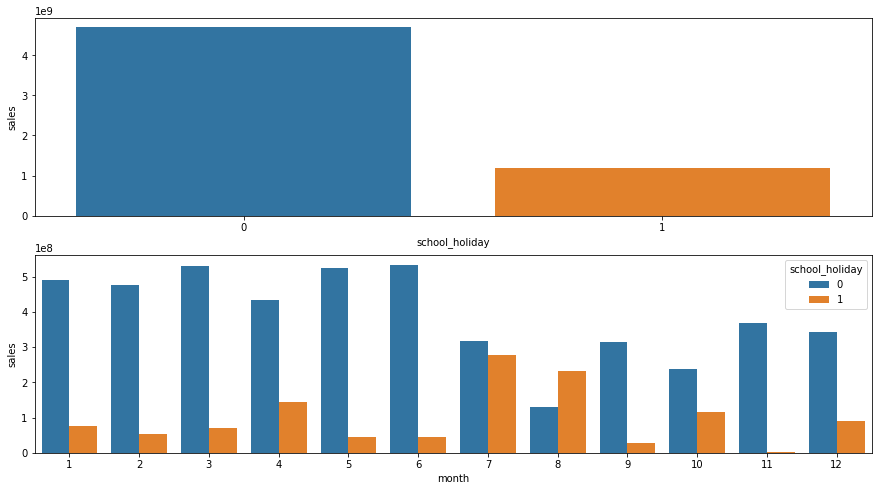

In [42]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x = 'month', y = 'sales', hue='school_holiday', data = aux2);


## 4.3 - Multivariable Analysis

### 4.3.1 - Numerical Attributes

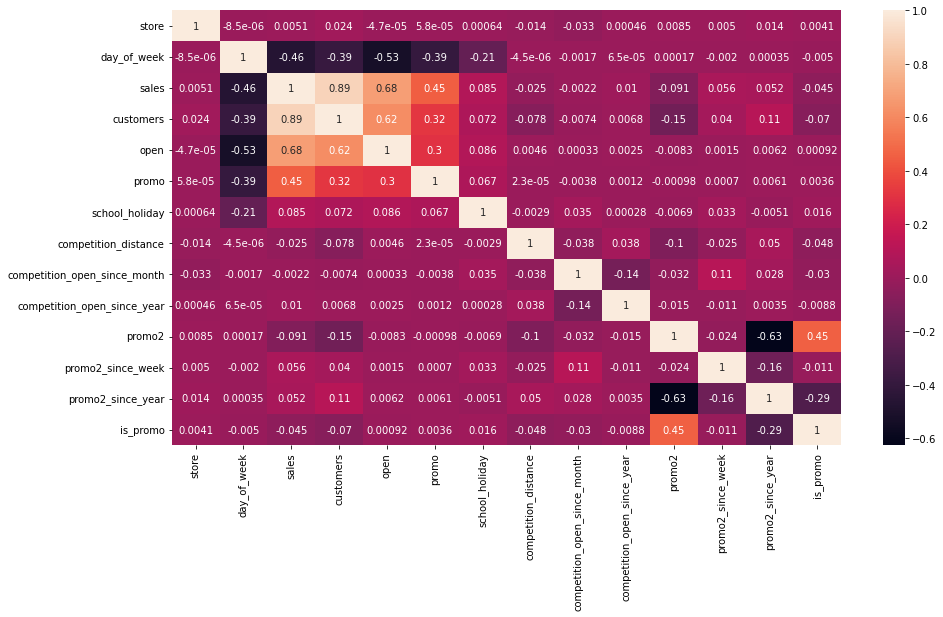

In [46]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap (correlation, annot=True);

### 4.3.2 - Categorical Attributes

In [48]:
a = df4.select_dtypes(include='object')
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [66]:
# Crámer's V Calculation
def cramer_v (x, y):
    cm = pd.crosstab(x, y).values    
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))


In [67]:
cramer_v(a['state_holiday'], a['store_type'])

0.07106469715258833

In [71]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday': [a1,a2,a3],
              'store_type': [a4,a5,a6],
              'assortment': [a7,a8,a9]})

d = d.set_index(d.columns)

<AxesSubplot:>

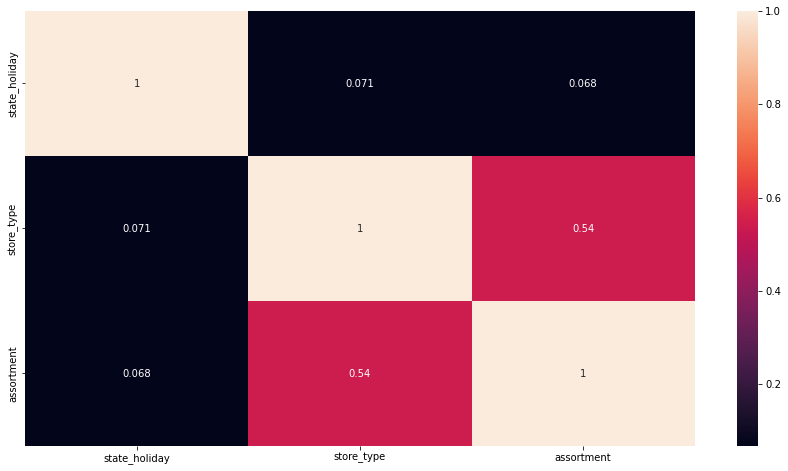

In [74]:
sns.heatmap(d, annot=True)